# Variational GP Regression with Pyro

In [1]:
import math
import torch
import pyro
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/gpleiss/anaconda3/envs/gpytorch/lib/python3.7/site-packages/matplotlib/__init__.py:999: UserWarning: Duplicate key in file "/home/gpleiss/.dotfiles/matplotlib/matplotlibrc", line #57
  (fname, cnt))


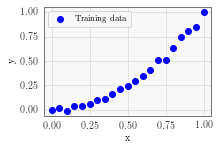

In [2]:
train_x = torch.linspace(0., 1., 21)
train_y = torch.pow(train_x, 2).mul_(3.7)
train_y = train_y.div_(train_y.max())
train_y += torch.randn_like(train_y).mul_(0.02)

fig, ax = plt.subplots(1, 1, figsize=(3, 2))
ax.plot(train_x.numpy(), train_y.numpy(), 'bo')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(['Training data'])

In [3]:
class PVGPRegressionModel(gpytorch.models.PyroVariationalGP):
    def __init__(self, train_x, train_y, likelihood, name_prefix="mixture_gp"):
        # Define all the variational stuff
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            num_inducing_points=train_y.numel(),
        )
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, train_x, variational_distribution
        )
        
        # Standard initializtation
        super(PVGPRegressionModel, self).__init__(variational_strategy, likelihood, num_data=train_y.numel())
        self.likelihood = likelihood
        
        # Mean, covar
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=1.5)
        )

    def forward(self, x):
        mean = self.mean_module(x)  # Returns an n_data vec
        covar = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

In [4]:
model = PVGPRegressionModel(train_x, train_y, gpytorch.likelihoods.GaussianLikelihood())

In [5]:
from pyro import optim
optimizer = optim.Adam({"lr": 0.01})

def train(num_iter=400):
    elbo = pyro.infer.Trace_ELBO(num_particles=256, vectorize_particles=True)
    svi = pyro.infer.SVI(model.model, model.guide, optimizer, elbo)
    model.train()

    for i in range(num_iter):
        model.zero_grad()
        loss = svi.step(train_x, train_y)
        if not (i + 1) % 50:
            print('Iter %d/%d - Loss: %.3f   log_lengthscale: %.3f   log_noise: %.3f' % (
                i + 1, num_iter, loss,
                model.covar_module.base_kernel.log_lengthscale.item(),
                model.likelihood.log_noise.item()
            ))
        
%time train()

Iter 50/400 - Loss: 26.642   log_lengthscale: -0.094   log_noise: -0.487
Iter 100/400 - Loss: 24.870   log_lengthscale: -0.075   log_noise: -0.939
Iter 150/400 - Loss: 20.312   log_lengthscale: -0.050   log_noise: -1.374
Iter 200/400 - Loss: 15.215   log_lengthscale: -0.031   log_noise: -1.823
Iter 250/400 - Loss: 7.134   log_lengthscale: 0.063   log_noise: -2.334
Iter 300/400 - Loss: -2.270   log_lengthscale: 0.163   log_noise: -2.990
Iter 350/400 - Loss: -11.049   log_lengthscale: 0.084   log_noise: -3.791
Iter 400/400 - Loss: -17.507   log_lengthscale: 0.072   log_noise: -4.556
CPU times: user 38.4 s, sys: 42.7 s, total: 1min 21s
Wall time: 11.7 s


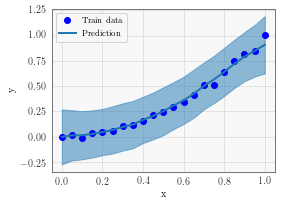

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
train_data, = ax.plot(train_x.cpu().numpy(), train_y.cpu().numpy(), 'bo')

model.eval()
with torch.no_grad():
    output = model.likelihood(model(train_x))
    
mean = output.mean
lower, upper = output.confidence_region()
line, = ax.plot(train_x.cpu().numpy(), mean.detach().cpu().numpy())
ax.fill_between(train_x.cpu().numpy(), lower.detach().cpu().numpy(),
                upper.detach().cpu().numpy(), color=line.get_color(), alpha=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend([train_data, line], ['Train data', 'Prediction'])